### 1. Introducción

Esta es la solución de la prueba técnica de Bancolombia para el puesto de científico de datos. El problema consiste en predecir si clientes morosos van a aceptar opciones alternativas de pago ofrecidas por el banco. Para más detalles, por favor referirse al reporte entregado.

### 2. Exploración y limpieza de datos

In [1]:
#Librerías usadas.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
# Cargar datos de .cvs a un diccionatio de data frames de pandas.
data = {'pivot_test': pd.read_csv('prueba_op_base_pivot_var_rpta_alt_enmascarado_trtest.csv'),
        'cuotas':pd.read_csv('prueba_op_maestra_cuotas_pagos_mes_hist_enmascarado_completa.csv'),
        'customers':pd.read_csv('prueba_op_master_customer_data_enmascarado_completa.csv'),
        'data_prob':pd.read_csv('prueba_op_probabilidad_oblig_base_hist_enmascarado_completa.csv')} # Datos para el modelo.

data_oot = pd.read_csv('prueba_op_base_pivot_var_rpta_alt_enmascarado_oot.csv') # Datos para predicciones y resultados.

# Organizar datos por nit.
for key in data:
    data[key] = data[key].sort_values(by='nit_enmascarado')
    data[key] = data[key].reset_index(drop=True)

data_oot = data_oot.sort_values(by='nit_enmascarado')
data_oot = data_oot.reset_index(drop=True)

In [3]:
# Para visualizar.
#data['pivot_test']

In [4]:
# Para visualizar.
# data['pivot_test']

In [5]:
# Para visualizar.
# data['customers']

In [6]:
# Para visualizar.
#data['data_prob']

In [7]:
# Para visualizar.
#data_oot

Por simple inspección de las tablas, es posible concluir que no todos los sets de datos disponibles tienen exactamente los nits de los mismos clientes. Por lo tanto, es necesario investigar qué datos de qué clientes tenemos disponibles para poder hacer predicciones. En las siguientes celdas exploramos la cantidad de clientes en cada set de datos. Además exploramos qué información podemos obtener de los clientes que queremos analizar (aquellos en data_oot). Empecemos por ver si tenemos información de todos los clientes que queremos analizar en data['pivot_test'], el set de datos que contiene información sobre mora.

In [8]:
# Comparar los nits de d['pivot_test'] con los datos de clientes a ser predecidos.
nits_test = data['pivot_test']['nit_enmascarado'].unique()
nits_oot = data_oot['nit_enmascarado'].unique()
np.isin(nits_oot, nits_test).sum() == len(nits_oot) # Chequeo para ver si los nits de clientes que queremos analizar están en data['pivot_test'].

False

Asumiendo que los datos data['pivot_test'] están completos (es decir, que contienen toda la información de clientes en mora del banco), se puede concluir que hay nuevos clientes en mora para enero del 2024. No hay información de mora que podamos usar para estos nuevos clientes. Es importante recalcar que clientes que estuvieran anteriormente en mora con algunos productos hayan adquirido mora en nuevas obligaciones. Por simplicidad, en este proyecto usaremos los datos disponibles en data['pivot_test'], aún cuando no tenemos datos históricas de mora de algunos clientes y productos. Generaremos estos datos de forma sintética basándonos en los datos disponibles. Cabe resaltar que con la información que tenemos es posible usar datos de sets cómo data['customers'], los cuales tienen información de algunos de los clientes que no tienen historial de mora. En principio, podríamos usar los resultados de los clientes y productos que tienen hisotrial de mora para encontrar correlaciones entre la aceptación de opciones de pago y las caractrísticas del set data['customers']. Luego, podríamos usar estas correlaciones para hacer predicciones de los clientes que no tienen historial de mora. Por cuestiones de tiempo, lo dejaremos para otra ocasión y nos enfocaremos en data['pivot_test']. Procedamos a limpiar los datos para construir un modelo para hacer predicciones con data['pivot_test']. 

In [9]:
# Chequeo de valores faltantes (NaN's)
data['pivot_test'].isna().sum()

nit_enmascarado                         0
num_oblig_orig_enmascarado              0
num_oblig_enmascarado                   0
fecha_var_rpta_alt                      0
var_rpta_alt                            0
tipo_var_rpta_alt                       0
banca                                   0
segmento                                0
producto                                0
producto_cons                           0
aplicativo                              0
min_mora                                0
max_mora                                0
dias_mora_fin                           0
rango_mora                              0
vlr_obligacion                        666
vlr_vencido                             0
saldo_capital                           0
endeudamiento                           0
desc_alternativa1                       0
desc_alternativa2                       0
desc_alternativa3                       0
cant_alter_posibles                     0
alter_posible1_2                  

Observamos que hay 11 columnas de data['pivot_test'] con valores faltantes. La forma de lidiar con estos valores faltantes dependerá de cada característica en particular. Por ejmplo, en el caso de la columna rpc, correspondiente a la cantidad de contactos con el cliente, podemos reemplazar los valores faltantes ya sea con un número fijo (0, por ejemplo), o con la media o la mediana de esta columna. Intuitivamente, si hay datos faltantes de contactos con clientes, lo más probable será que no se hizo ninguno. Por lo tanto, reemplazamos los valoes faltantes con 0's. Para valores faltantes en características categóricas (no numéricas) que consideremos relevantes para el modelo, podemos proponer la existencia de nuevas categorías cómo N.A (no aplica), OTRO, etc. Empecemos por las columnas con valores numéricos faltantes.

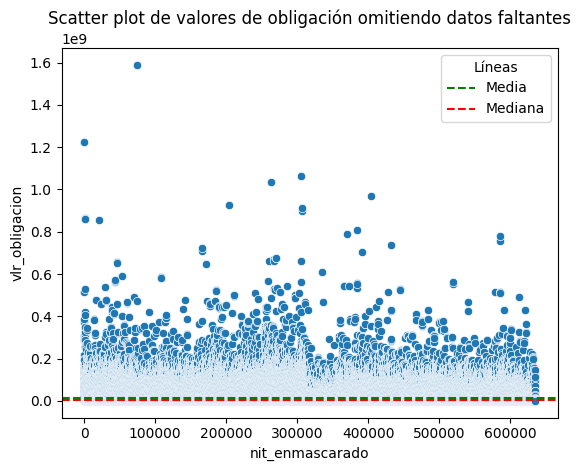

In [10]:
# Observación del valor de obligación para tomar decisión sobre cómo llenar los valores faltantes.
sns.scatterplot(data=data['pivot_test'], x='nit_enmascarado', y='vlr_obligacion')
plt.axhline(data['pivot_test']['vlr_obligacion'].mean(skipna=True), color='green', linestyle='--', label='Media') # Línea que representa la media.
plt.axhline(data['pivot_test']['vlr_obligacion'].median(skipna=True), color='red', linestyle='--', label='Mediana') # Línea que representa la mediana.
plt.title('Scatter plot de valores de obligación omitiendo datos faltantes')
plt.legend(title="Líneas")

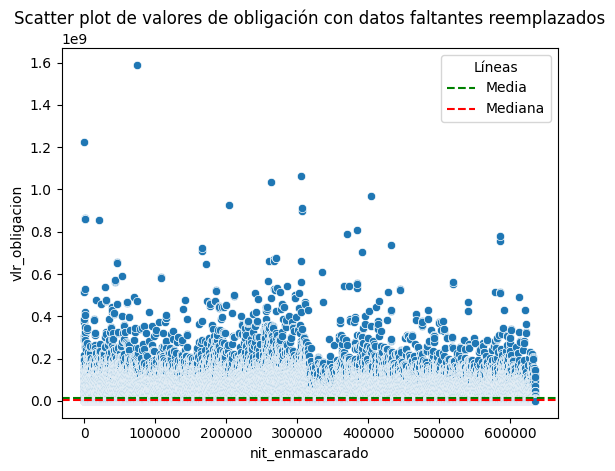

In [11]:
# La gráfica sugiere que podemos reemplazar los valores faltantes por la media o la mediana de los datos sin alterar de manera significativa los datos.
data['pivot_test']['vlr_obligacion'] = data['pivot_test']['vlr_obligacion'].fillna(data['pivot_test']['vlr_obligacion'].mean()) # Llenar datos faltantes.
sns.scatterplot(data=data['pivot_test'], x='nit_enmascarado', y='vlr_obligacion') # seaborn ignora NaN's para graficar.
plt.axhline(data['pivot_test']['vlr_obligacion'].mean(skipna=True), color='green', linestyle='--', label='Media') # Línea que representa la media.
plt.axhline(data['pivot_test']['vlr_obligacion'].median(skipna=True), color='red', linestyle='--', label='Mediana') # Línea que representa la mediana.
plt.title('Scatter plot de valores de obligación con datos faltantes reemplazados')
plt.legend(title="Líneas")

In [12]:
# Siguiendo una lógica similar, reemplazamos las demás características numéricas faltantes de la siguiente forma.
data['pivot_test']['cant_gestiones'] = data['pivot_test']['cant_gestiones'].fillna(int(data['pivot_test']['cant_gestiones'].mean()))
data['pivot_test']['rpc'] = data['pivot_test']['rpc'].fillna(0)
data['pivot_test']['cant_acuerdo'] = data['pivot_test']['cant_acuerdo'].fillna(int(data['pivot_test']['cant_acuerdo'].mean()))
data['pivot_test']['valor_cuota_mes'] = data['pivot_test']['valor_cuota_mes'].fillna(data['pivot_test']['valor_cuota_mes'].mean())
data['pivot_test']['pago_cuota'] = data['pivot_test']['pago_cuota'].fillna(data['pivot_test']['pago_cuota'].mean())
data['pivot_test']['porc_pago_mes'] = data['pivot_test']['porc_pago_mes'].fillna(data['pivot_test']['porc_pago_mes'].mean())

# Para lidiar con las características categóricas, creamos una nueva categoría llamada N.A (no aplica) para códigos de opciones de pago, NINGUNA para opciones de pago y la tipología más general. 
data['pivot_test']['alter_posible2_2'] = data['pivot_test']['alter_posible2_2'].fillna('N.A')
data['pivot_test']['alter_posible3_2'] = data['pivot_test']['alter_posible3_2'].fillna('N.A')
data['pivot_test']['alternativa_aplicada_agr'] = data['pivot_test']['alternativa_aplicada_agr'].fillna('NINGUNA')
data['pivot_test']['marca_agrupada_rgo'] = data['pivot_test']['marca_agrupada_rgo'].fillna('NINGUNA')

In [13]:
# Chequeo de valores faltantes después del procesamiento.
data['pivot_test'].isna().sum()

nit_enmascarado                    0
num_oblig_orig_enmascarado         0
num_oblig_enmascarado              0
fecha_var_rpta_alt                 0
var_rpta_alt                       0
tipo_var_rpta_alt                  0
banca                              0
segmento                           0
producto                           0
producto_cons                      0
aplicativo                         0
min_mora                           0
max_mora                           0
dias_mora_fin                      0
rango_mora                         0
vlr_obligacion                     0
vlr_vencido                        0
saldo_capital                      0
endeudamiento                      0
desc_alternativa1                  0
desc_alternativa2                  0
desc_alternativa3                  0
cant_alter_posibles                0
alter_posible1_2                   0
alter_posible2_2                   0
alter_posible3_2                   0
cant_gestiones                     0
c

Será también conveniente concatenar los tres nits presentes en las primeras tres columnas de data['pivot_test'] y de data_oot para construir una característica (de tipo string) nueva llamada 'ID' de la forma nit_enmascarado#num_oblig_orig_enmascarado#num_oblig_enmascarado. Ya que trabajar con strings es poco práctico, en especial en librerías como NumPy, construiremos un número entero asociado a cada uno de los ID's que llamaremos ID_prod_sum, definido cómo: ID_prod_sum = (nit_enmascarado x num_oblig_orig_enmascarado xnum_oblig_enmascarado) + nit_enmascarado + num_oblig_orig_enmascarado. En principio, operaciones de este tipo no garantizan que se le asigne un valor numérico único a la string 'ID'. Uno puede generar el mismo número combinando de formas distintas distintos números. Sin embargo, esta combinación funciona bien con los datos disponibles, cómo chequeamos al final de la siguiente celda.

In [14]:
# Concatenar nits.
data_pt_ID = data['pivot_test'].copy()
data_pt_ID['ID'] = data_pt_ID[['nit_enmascarado', 'num_oblig_orig_enmascarado', 'num_oblig_enmascarado']].astype(str).agg('#'.join, axis=1)
data_pt_ID['ID_prod'] = data_pt_ID[['nit_enmascarado','num_oblig_orig_enmascarado', 'num_oblig_enmascarado']].prod(axis=1)
data_pt_ID['ID_prod_sum'] = data_pt_ID[['ID_prod', 'nit_enmascarado','num_oblig_orig_enmascarado']].sum(axis=1) # Codificar cada cliente con su producto en un número entero.
data_pt_ID.insert(0, 'ID', data_pt_ID.pop('ID'))
data_pt_ID.insert(0, 'ID_prod_sum', data_pt_ID.pop('ID_prod_sum'))
data_pt_ID.pop('ID_prod')

data_oot_ID = data_oot.copy()
data_oot_ID['ID'] = data_oot_ID[['nit_enmascarado', 'num_oblig_orig_enmascarado', 'num_oblig_enmascarado']].astype(str).agg('#'.join, axis=1)
data_oot_ID['ID_prod'] = data_oot_ID[['nit_enmascarado','num_oblig_orig_enmascarado', 'num_oblig_enmascarado']].prod(axis=1)
data_oot_ID['ID_prod_sum'] = data_oot_ID[['ID_prod', 'nit_enmascarado','num_oblig_orig_enmascarado']].sum(axis=1) # Codificar cada cliente con su producto en un número entero.
data_oot_ID.insert(0, 'ID', data_oot_ID.pop('ID'))
data_oot_ID.insert(0, 'ID_prod_sum', data_oot_ID.pop('ID_prod_sum'))
data_oot_ID.pop('ID_prod')

# Chequear que haya la misma cantidad de Id's en los números obenidos con las operaciones matemáticas y en la concatenación.
# Esto garantiza que haya un número entero asociado a cada uno de los ID's que combinan todos los nits. 
print(data_pt_ID['ID_prod_sum'].nunique() == data_pt_ID['ID'].nunique())
print(data_oot_ID['ID_prod_sum'].nunique() == data_oot_ID['ID'].nunique())

True
True


### 3. Construcción, entrenamiento y evaluación del modelo

A continuación construimos un modelo basasdo en el método Random Forest para predecir si los clientes que han tenido mora antes de enero del 2024 aceptarán una opción de pago. Justificamos el uso de Random Forest en esta situación por su capacidad de trabajar con no-linealidades y su robustez. Es importante aclarar lo siguiente. En la etapa de desarrollo de este problema, se encontró que la cantidad de características categóricas de data['pivot_test'] y el uso de codificación de estas en valores numéricos (One-Hot encoding) causaban problemas. One-Hot encoding genera columnas con valores binarios asociados a las características categóricas. Es posible que estas columnas añadidas, las cuales aumetan las dimensiones del set de datos significativamente, pudieran tener alguna relación no trivial con la variable respuesta, causando overfitting y problemas de generalización. Para mitigar estos problemas, en el desarrollo del modelo vamos a conservar variables categóricas que sean absolutamente necesarias, eliminando aquellas no consideremos que lo sean. Vale la pena mencionar que hay información redundante en el set de datos. Por ejemplo, las dos últimas columnas del data['pivot_test'] contienen básicamente la misma información que la variable respuesta. Estos datos, si no se eliminan, causan problemas por overfitting. Vale la pena aclarar que teniendo más tiempo sería importante hacer una investigación exhaustiva de la razón precisa o característica particular que cause problemas de generalización en el modelo. Por el momento, sin embargo, tomaremos un camino más pragmático. 

In [15]:
# Garantizar que las características de los datos de entrenamiento coincidan con las características de los datos que analizaremos luego.
car_cate_rel = ['alter_posible1_2', 'alter_posible2_2', 'alter_posible3_2', 
                'rango_mora', 'alternativa_aplicada_agr', 'marca_pago'] # Creae lista de características categóricas relevantes.
# Filtrar datos para ver qué características tienen los clientes que ya tienen historial de mora.
data_pt_ID_filtered = data_pt_ID[data_pt_ID['ID_prod_sum'].isin(data_oot_ID['ID_prod_sum'].to_numpy())] 
data_pt_ID = data_pt_ID[data_pt_ID[car_cate_rel].apply(tuple, axis=1).isin(data_pt_ID_filtered[car_cate_rel].apply(tuple, axis=1))] # Eliminar datos con características problemáticas del set de entramiento.

In [16]:
data_p = data_pt_ID[data_pt_ID.select_dtypes(exclude=['category', 'object']).columns.tolist() + car_cate_rel]
data_p = data_p.reset_index(drop=True)
data_p_enc = pd.get_dummies(data_p, columns=car_cate_rel) # One-Hot encoding the las variables categóricas.

In [17]:
# Construcción y entrenamiento del modelo.
X = data_p_enc.drop(columns=['var_rpta_alt']) # Datos para entrenar y testear.
y = data_pt_ID['var_rpta_alt'] # Objetivos.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Partir los datos en entrenamiento y test.

model = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42, min_samples_leaf=1, min_samples_split=2, class_weight="balanced", bootstrap=True) # Definición del modelo
# Los parámetros elegidos para la construcción del modelo fueron hayados con métodos de optimización de hiperparámetros. Ver código más abajo.
#Best Parameters from Grid Search:{'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

model.fit(X_train, y_train) # Entrenamiento del modelo.

y_pred = model.predict(X_test) # Predicciones en el set de testeo.

# Evaluación del modelo.

f1_modelo = f1_score(y_test, y_pred, zero_division=0)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(f"\nf1 Modelo:{f1_modelo:.2f}")

Accuracy: 0.91

f1 Modelo:0.90


El modelo que construimos tiene un buen f1-score, lo cual indica que es un modelo que podemos confiar. Sin embargo, para estar seguros de que el modelo presenta un mejor desempeño que métricas base (Baseline metrics), las cuales en este proyecto generamos con un método llamado Majority Class. El método asume que el modelo siempre retornará como predicción la clase (0 0 1, aceptará o no aceptará) que aparezca más frecuentemente en los datos. 

In [18]:
# Encontrar métricas base para comparar con el desempeño del modelo.
majority_class = y_train.value_counts().idxmax() # Encontrar la clase (0 o 1) que ocurre con mayor frecuencia.
baseline_predic = [majority_class] * len(y_test) # Generar lista con valores más frecuentes.

# Calcular métricas base
base_accuracy = accuracy_score(y_test, baseline_predic)
base_f1 = f1_score(y_test, baseline_predic, pos_label=majority_class, zero_division=0)
print(f"f1 Base:{base_f1:.2f}")
print(f"\nf1 Modelo:{f1_modelo:.2f}")

f1 Base:0.69

f1 Modelo:0.90


Estos resultados indican que el modelo funciona significativamente mejor que el Majority Class. Por lo tanto, lo consideramos un modelo viable.

In [19]:
# Este es el código usado para optimizar parámetros para optimizar f1. Es un proceso que toma mucho tiempo. ¡Evitar correr esta celda!
"""
# ---- Hyperparameter Tuning ----
# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200],  # Reduce the range of number of trees
    'max_depth': [10, 20],  # Limit depth options
    'min_samples_split': [2, 10],  # Fewer options for split criteria
    'min_samples_leaf': [1, 4],    # Fewer options for leaf criteria
    'bootstrap': [True],          # Keep only bootstrap=True
}

# Grid Search with 5-fold Cross-Validation
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    scoring='f1',  # You can use 'f1', 'roc_auc', or another metric
    cv=5,
    verbose=2,
    n_jobs=-1
)

print("\nTuning Hyperparameters...")
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

print("\nBest Parameters from Grid Search:")
print(grid_search.best_params_)

# ---- Model Evaluation ----
# Make predictions using the best model
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate model metrics
model_accuracy = accuracy_score(y_test, y_pred)
model_precision = precision_score(y_test, y_pred, pos_label=majority_class)
model_recall = recall_score(y_test, y_pred, pos_label=majority_class)
model_f1 = f1_score(y_test, y_pred, pos_label=majority_class)
model_auc = roc_auc_score(y_test, y_pred_proba)

# ---- Comparison Table ----
print("\nComparison of Model vs Baseline:")
print(f"{'Metric':<12} {'Baseline':<10} {'Model':<10}")
print(f"{'Accuracy':<12} {base_accuracy:.2f}      {model_accuracy:.2f}")
print(f"{'F1-Score':<12} {base_f1:.2f}      {model_f1:.2f}")
print(f"{'AUC-ROC':<12} {'N/A':<10}      {model_auc:.2f}")
"""

'\n# ---- Hyperparameter Tuning ----\n# Define the parameter grid for Random Forest\nparam_grid = {\n    \'n_estimators\': [100, 200],  # Reduce the range of number of trees\n    \'max_depth\': [10, 20],  # Limit depth options\n    \'min_samples_split\': [2, 10],  # Fewer options for split criteria\n    \'min_samples_leaf\': [1, 4],    # Fewer options for leaf criteria\n    \'bootstrap\': [True],          # Keep only bootstrap=True\n}\n\n# Grid Search with 5-fold Cross-Validation\ngrid_search = GridSearchCV(\n    RandomForestClassifier(random_state=42),\n    param_grid,\n    scoring=\'f1\',  # You can use \'f1\', \'roc_auc\', or another metric\n    cv=5,\n    verbose=2,\n    n_jobs=-1\n)\n\nprint("\nTuning Hyperparameters...")\ngrid_search.fit(X_train, y_train)\nbest_model = grid_search.best_estimator_\n\nprint("\nBest Parameters from Grid Search:")\nprint(grid_search.best_params_)\n\n# ---- Model Evaluation ----\n# Make predictions using the best model\ny_pred = best_model.predict(X_t

### 4. Implementación del modelo (inferencia)

Habiendo construido y evaluado el modelo en la sección anterior, en esta sección lo usaremos para hacer las predicciones necesarias. Con este fin en mente, el primer paso es organizar los datos que debemos analizar, los cuales están contenidos en data_oot_ID. Para hacer predicciones, debemos ver qué ID's están en los datos data_pt_ID y completar lo que podamos en data_oot_ID, ya sea con la información de data_pt_ID o generando datos sintéticos.

In [20]:
# Unir datos filtrados con los datos de las personas que no tenían historia morosa antes de enero del 2024.
data_pt_ID_filtered = data_pt_ID_filtered.drop(columns=['fecha_var_rpta_alt', 'var_rpta_alt'])

merged_data = pd.merge(data_oot_ID, data_pt_ID_filtered, on=['ID', 'ID_prod_sum', 'nit_enmascarado', 'num_oblig_orig_enmascarado', 'num_oblig_enmascarado'], how='left')  

In [21]:
# Llenar datos faltantes. Numéricos con media, categóricos con moda.
for column in merged_data.columns:
    if pd.api.types.is_numeric_dtype(merged_data[column]):
    
        min_val = merged_data[column].min()
        max_val = merged_data[column].max()

        mean_val = merged_data[column].mean()
        std_val = merged_data[column].std()

        def random_normal(min_val, max_val, mean, std):
            return np.random.normal(mean, std)
        
        random_values = merged_data[column].isna()
        merged_data.loc[random_values, column] = merged_data.loc[random_values, column].apply(
            lambda x: random_normal(min_val, max_val, mean_val, std_val)
        ) # Rellenar NaNs con valores aleatorios en cada columna numérica.

    else:

        if merged_data[column].dtype == 'object' and not merged_data[column].mode().empty:

            non_missing_values = merged_data[column].dropna().unique()
            merged_data[column] = merged_data[column].apply(
                lambda x: np.random.choice(non_missing_values) if pd.isna(x) else x
            ) # Rellenar NaNs con valores categóricos aleatorios.

data_for_pred = merged_data[merged_data.select_dtypes(exclude=['category', 'object']).columns.tolist() + car_cate_rel]
X_for_pred = pd.get_dummies(data_for_pred, columns=car_cate_rel) # One-Hot encoding the las variables categóricas.

In [22]:
# Hacer predicciones finales.
Y_for_pred = model.predict(X_for_pred)
Y_prob = model.predict_proba(X_for_pred)
result = pd.DataFrame({'ID': merged_data['ID'], 'var_rpta_alt':Y_for_pred, 'Prob_uno':Y_prob[:, 1]})

In [23]:
# Ajustar tamaño de los datos para predicción final y guardar datos.
result = result.drop_duplicates(subset='ID', keep='first')
result = result.reset_index(drop=True)
result.to_csv('predic_bancolombia_prob.csv', index=False, encoding='utf-8', columns=['ID', 'var_rpta_alt', 'Prob_uno']) # Guardar datos en .cvs (incluyendo probabilidades).
result = result.drop(columns='Prob_uno')
result.to_csv('predic_bancolombia.csv', index=False, encoding='utf-8', columns=['ID', 'var_rpta_alt']) 
pd.read_csv('predic_bancolombia.csv') # Guardar datos en .cvs (sin probabilidades).

,ID,var_rpta_alt
0,12#623302#457040,1
1,24#91197#996548,1
2,29#463300#617042,1
3,39#817198#263144,0
4,55#813213#267129,1
...,...,...
112544,634681#335716#744868,1
112545,634681#193982#894270,1
112546,634685#53619#1051333,1
112547,634695#446928#633420,0
